## **Self RAG**

SELF-RAG is a method that improves the accuracy and quality of text generated by a language model (LM). It does this by using retrieval to find relevant information and allowing the model to reflect on its output.

The model generates text with the help of retrieved passages, and then it checks its own response by creating reflection tokens. These tokens tell the model if it needs more information or if the answer is complete and supported by the retrieved data.

Research Paper: [Self RAG](https://arxiv.org/pdf/2310.11511)


## **Initial Setup**

In [ ]:
! pip install --q athina faiss-gpu langgraph

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ['ATHINA_API_KEY'] = userdata.get('ATHINA_API_KEY')

## **Indexing**

In [ ]:
# load embedding model
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [ ]:
# load data
from langchain.document_loaders import CSVLoader
loader = CSVLoader("./context.csv")
documents = loader.load()

In [ ]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
documents = text_splitter.split_documents(documents)

In [ ]:
# create vectorstore
from langchain.vectorstores import FAISS
vectorstore = FAISS.from_documents(documents, embeddings)

## **Retriever**

In [ ]:
# create retriever
retriever = vectorstore.as_retriever()

## **Document Grader**
The document grader evaluates whether a document is relevant to the given query.

In [ ]:
# create grader for doc retriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# define a data class
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt for the grader
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [ ]:
# testing grader
question = "what are points on a mortgage"
docs = retriever.invoke(question)
print(retrieval_grader.invoke({"question": question, "document": docs}))

binary_score='yes'


## **RAG Chain**

In [ ]:
# create document chain
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

template = """"
You are a helpful assistant that answers questions based on the following context
Context: {context}
Question: {question}
Answer:

"""

prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

In [ ]:
# response
generation = rag_chain.invoke({"context": docs, "question": question})
generation

"Points on a mortgage, also known as discount points, mortgage points, or simply points, are a form of pre-paid interest that can be paid by a borrower to a lender when arranging a mortgage. One point is equal to one percent of the loan amount. By paying points, a borrower can effectively reduce the interest rate on the loan, resulting in a lower monthly payment. Points can also be used to qualify for a loan based on monthly income versus the monthly loan payment. It's important to note that points are different from origination fees, mortgage arrangement fees, or broker fees."

## **Hallucination Grader**
The hallucination grader checks whether the answer is grounded in or supported by the given set of facts

In [ ]:
# create grader for hallucination
# define a data class
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# prompt for the grader
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## **Answer Grader**
The answer grader evaluates whether an answer effectively addresses the given question.

In [ ]:
# create grader for answer
# define a data class
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# prompt for the grader
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## **Create Graph**

### **Define Graph State**

In [ ]:
# define a data class for state
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [ ]:
# # define graph steps
# from langchain.schema import Document

# all nodes
def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


# edges
def decide_to_generate(state):

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION---"
        )
        return "no_relevant_documents"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### **Build Graph**

In [ ]:
# Build graph
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "no_relevant_documents": END,
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
    },
)

# Compile
app = workflow.compile()

In [ ]:
# Final generation example 1 (relevant documents)
from pprint import pprint

inputs = {"question": "what are points on a mortgage"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

if "generation" in value:
    pprint(value["generation"])
else:
    pprint("No relevant documents found or no generation produced.")

---RETRIEVE---


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Points on a mortgage, also known as discount points, are a form of pre-paid '
 'interest that borrowers can pay to a lender when arranging a mortgage in the '
 'United States. One point equals one percent of the loan amount. By paying '
 'points, a borrower can reduce the interest rate on the loan, resulting in a '
 'lower monthly payment. Points can also be used to qualify for a loan based '
 "on monthly income versus the monthly loan payment. It's important to note "
 'that points are different from 

In [ ]:
# example 2 (no relevant documents)
from pprint import pprint

inputs = {"question": "Explain how the different types of agent memory work?"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

if "generation" in value:
    pprint(value["generation"])
else:
    pprint("No relevant documents found or no generation produced.")

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION---
"Node 'grade_documents':"
'\n---\n'
'No relevant documents found or no generation produced.'


## **Preparing Data for Evaluation**

In [ ]:
# Create a dataframe to store the question, context, and response
inputs = {"question": "what are points on a mortgage"}
outputs = []


for output in app.stream(inputs):
    for key, value in output.items():
        if key == "generate":  # Assuming 'generate' node produces the final output
            question = value["question"]
            documents = value["documents"]
            generation = value["generation"]

            # Combine document contents into a single string
            context = "\n".join(doc.page_content for doc in documents)

            # Append the result
            outputs.append({
                "query": question,
                "context": context,
                "response": generation,
            })

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


In [ ]:
# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(outputs)

In [ ]:
df

,query,context,response
0,what are points on a mortgage,"context: [""Discount points, also called mortga...","Points on a mortgage, also known as discount p..."


In [ ]:
# Convert to dictionary
df_dict = df.to_dict(orient='records')

# Convert context to list
for record in df_dict:
    if not isinstance(record.get('context'), list):
        if record.get('context') is None:
            record['context'] = []
        else:
            record['context'] = [record['context']]

## **Evaluation in Athina AI**

We will use **Does Response Answer Query** eval here. It Checks if the response answer the user's query. To learn more about this. Please refer to our [documentation](https://docs.athina.ai/api-reference/evals/preset-evals/overview) for further details.

In [ ]:
# set api keys for Athina evals
from athina.keys import AthinaApiKey, OpenAiApiKey
OpenAiApiKey.set_key(os.getenv('OPENAI_API_KEY'))
AthinaApiKey.set_key(os.getenv('ATHINA_API_KEY'))

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_generate_schema.py:386: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [ ]:
# load dataset
from athina.loaders import Loader
dataset = Loader().load_dict(df_dict)

In [ ]:
# evaluate
from athina.evals import DoesResponseAnswerQuery
DoesResponseAnswerQuery(model="gpt-4o").run_batch(data=dataset).to_df()

You can view your dataset at: https://app.athina.ai/develop/7ad4a012-9202-4a5e-a131-769f0e6c620c


,query,context,response,expected_response,display_name,failed,grade_reason,runtime,model,passed
0,what are points on a mortgage,"[context: [""Discount points, also called mortgage points or simply points, are a form of pre-paid interest available in the United States when arranging a mortgage. One point equals one percent of the loan amount. By charging a borrower points, a lender effectively increases the yield on the loan above the amount of the stated interest rate. Borrowers can offer to pay a lender points as a method to reduce the interest rate on the loan, thus obtaining a lower monthly payment in exchange for ...","Points on a mortgage, also known as discount points, are a form of pre-paid interest that borrowers can pay to a lender when arranging a mortgage in the United States. One point equals one percent of the loan amount. By paying points, a borrower can reduce the interest rate on the loan, resulting in a lower monthly payment. Points can also be used to qualify for a loan based on monthly income versus the monthly loan payment. It's important to note that points are different from origination f...",None,Does Response Answer Query,False,"The response provides a clear and detailed explanation of what points on a mortgage are. It explains that points are a form of pre-paid interest, how they are calculated (one point equals one percent of the loan amount), and their purpose (to reduce the interest rate and monthly payment). Additionally, it distinguishes points from other fees such as origination fees, mortgage arrangement fees, or broker fees. This sufficiently covers the user's query about points on a mortgage.",1704,gpt-4o,1.0


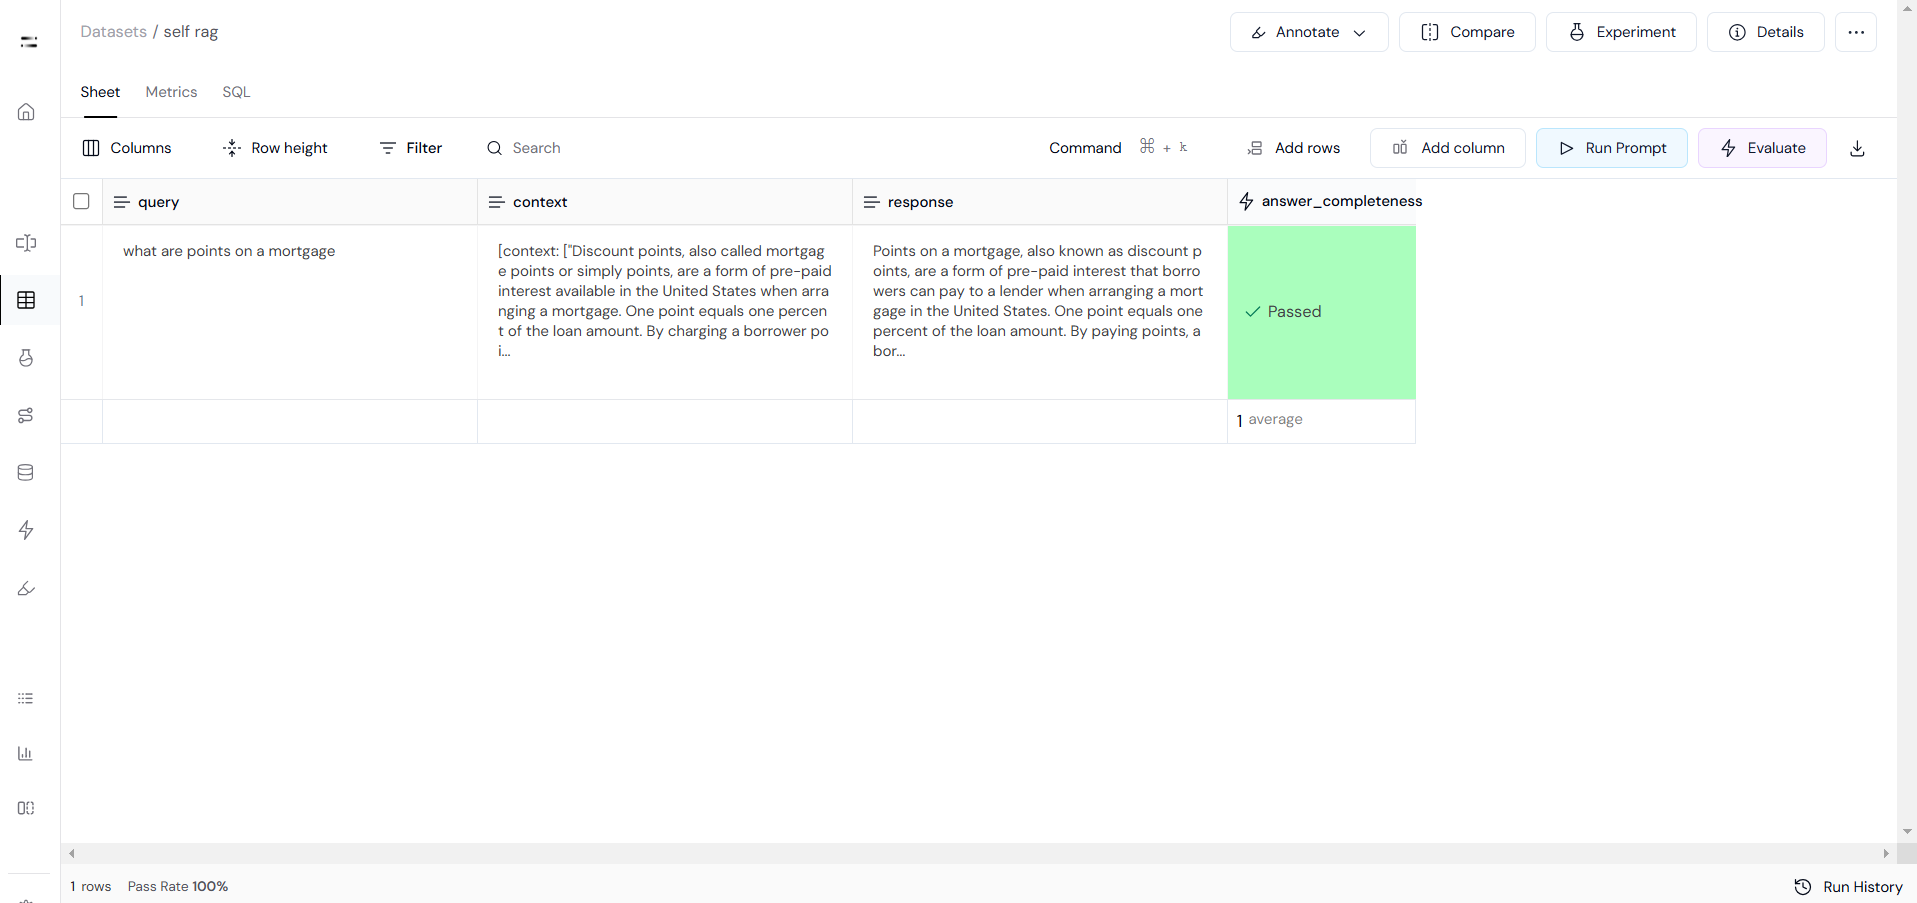